In [2]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)


/fileonssd/lard-dataset
/home/yeli/workspace/lard/lard-detection


# Visulize detections 结果可视化

In [4]:
import json
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random

CONFIDENCE_THRESHOLD = 0.35

# Define files 文件定义
annotation_file = f'{ROOT_DATA}/annotations/instances_test_real_nominal.json'
prediction_file = f'{ROOT_PROJECT}/runs/ultralytics/base/yolov8n_1280/test/test_real_nominal/predictions_modified.json'

# Get coco 初始化COCO对象
coco_true = COCO(annotation_file=annotation_file)
coco_pred = coco_true.loadRes(resFile=prediction_file)

# Get cls dict 获取类别字典
categories = coco_true.loadCats(coco_true.getCatIds())
catid_2_catname = {category['id']: category['name'] for category in categories}


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


In [5]:
# Get all image ids 获取全部图像ID
all_imgIds = coco_true.getImgIds()

# Get a random image 随机选一个图片
selected_imgIds = random.sample(all_imgIds, 1)
selected_imgIds = [1319]

In [7]:
# Get the info for the selected image 选中的图片的字典
img_dict = coco_true.loadImgs(selected_imgIds)[0]
img_name = img_dict["file_name"]
img_id = img_dict["id"]

# Read image 读取图像
image_path = f'{ROOT_DATA}/YoloFormat/detection/test_real_nominal/images/{img_name}'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get GT 获取GT
annIds = coco_true.getAnnIds(imgIds=img_id)  # get gt id based on image id 依据图像id查找gt的id
anns = coco_true.loadAnns(annIds)

# Get prediction 获取PRED
predIds = coco_pred.getAnnIds(imgIds=img_id)  # get pred id based on image id 依据图像id查找pred的id
preds = coco_pred.loadAnns(predIds)

print(img_name)
print(anns)
print(preds)

i8RhaLAUZ5g_070.png
[{'id': 1319, 'image_id': 1319, 'category_id': 0, 'bbox': [944.0, 206.00000000000003, 94.0, 104.0], 'area': 9776.0, 'iscrowd': 0}]
[{'image_id': 1319, 'category_id': 0, 'bbox': [943.333, 209.119, 94.992, 103.685], 'score': 0.75789, 'segmentation': [[943.333, 209.119, 943.333, 312.804, 1038.325, 312.804, 1038.325, 209.119]], 'area': 9849.24552, 'id': 204, 'iscrowd': 0}]


# Get random images 
# 随机获取图像

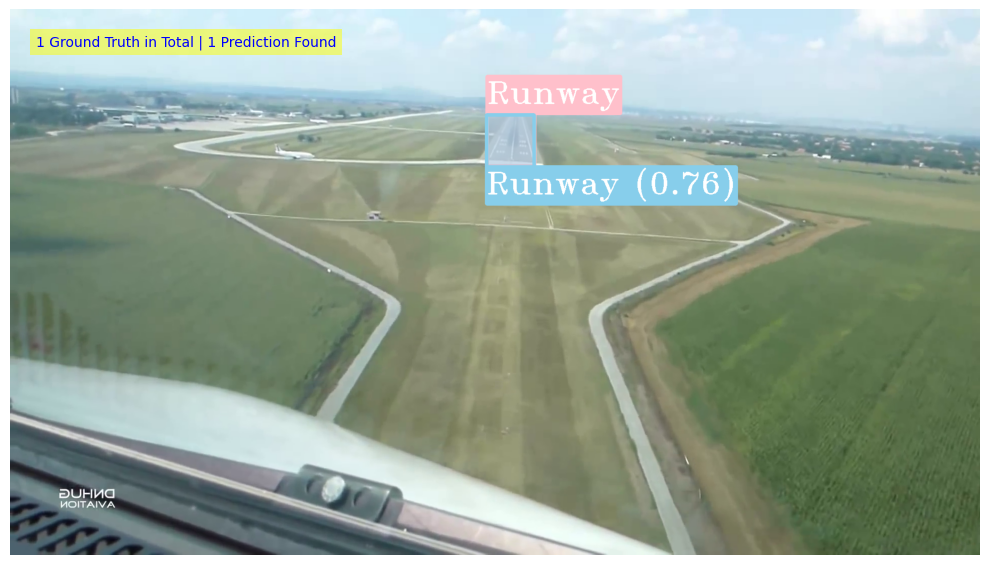

In [10]:
def draw_gt_pred(image, anns, preds, catid_2_catname: dict):
    
    # Font and plot params
    # 字体和绘图参数
    FONT_SCALE = 2
    FONT = cv2.FONT_HERSHEY_TRIPLEX
    LINE_WIDTH = 5
    COLOR_TEXT = (255, 255, 255)
    COLOR_GT = (255, 192, 203)  # Pink 粉色
    COLOR_PRED = (135, 206, 235)  # Blue 天蓝
    ALPHA = 0.4

    # Backup image
    # 备份图像
    img = image.copy()

    # Draw GT bbox
    # 绘制 GT bbox
    for ann in anns:

        # Bbox position
        # bbox位置
        x_left, y_top, w, h = [int(x) for x in ann['bbox']]
        x_right = x_left + w
        y_bottom = y_top + h
        label_id = ann['category_id']

        # Clse label
        # 类别label
        label_text = catid_2_catname[label_id]

        # Test [cls]
        # 文本 [类名称]
        text = label_text.capitalize()

        # Text size
        # 文字尺寸
        (w_text, h_text), _ = cv2.getTextSize(text, FONT, FONT_SCALE, 2)

        # Draw bbox
        # 绘制bbox
        cv2.rectangle(
            img,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_GT, LINE_WIDTH)
        # MASK
        overlay = img.copy()
        cv2.rectangle(
            overlay,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_GT, -1)
        cv2.addWeighted(overlay, ALPHA, img, 1 - ALPHA, 0, img)

        # Background of text
        # 绘制文字背景 bbox上部
        bg_x_right = x_right if w_text < w else x_left + w_text
        h_bias = 30
        # Fill in
        # 填充
        cv2.rectangle(
            img,
            (x_left, y_top),  # 左下角
            (bg_x_right, y_top-h_text-h_bias),  # 右上角
            COLOR_GT, -1)
        # Edge 
        # 边缘
        cv2.rectangle(
            img,
            (x_left, y_top),  # 左下角
            (bg_x_right, y_top-h_text-h_bias),  # 右上角
            COLOR_GT, LINE_WIDTH)

        # Text
        # 绘制文本
        cv2.putText(
            img,
            text,
            (x_left, y_top-20),
            FONT, FONT_SCALE, COLOR_TEXT, 2)

    # Draw pred bbox
    # 绘制 Pred bbox
    for pred in preds:

        # Bbox position
        # bbox位置
        x_left, y_top, w, h = [int(x) for x in pred['bbox']]
        x_right = x_left + w
        y_bottom = y_top + h

        # Cls label
        # 类别label
        label_id = pred['category_id']
        label_text = catid_2_catname[label_id]

        # Conf
        # 置信度
        score = pred['score']

        # Text [cls + conf]
        # 文本 [类别+置信度]
        text = f"{label_text} ({score:.2f})".capitalize()

        # Test size
        # 文字尺寸
        (w_text, h_text), _ = cv2.getTextSize(text, FONT, FONT_SCALE, 2)

        # Bbox
        # 绘制bbox
        cv2.rectangle(
            img,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_PRED, LINE_WIDTH)
        # MASK
        overlay = img.copy()
        cv2.rectangle(
            overlay,
            (x_left, y_top),
            (x_right, y_bottom),
            COLOR_PRED, -1)
        cv2.addWeighted(overlay, ALPHA, img, 1 - ALPHA, 0, img)

        # Background of text
        # 绘制文字背景 bbox上部
        bg_x_right = x_right if w_text < w else x_left + w_text
        h_bias = 30
        # Fill in
        # 填充
        cv2.rectangle(
            img,
            (x_left, y_bottom),  # 左上角
            (bg_x_right, y_bottom + h_text + h_bias),  # 右下角
            COLOR_PRED, -1)
        # Edge
        # 边缘
        cv2.rectangle(
            img,
            (x_left, y_bottom),  # 左上角
            (bg_x_right, y_bottom + h_text + h_bias),  # 右下角
            COLOR_PRED, LINE_WIDTH)
        # Text
        # 绘制文本
        cv2.putText(
            img,
            text,
            (x_left, y_bottom + h_text + 10),
            FONT, FONT_SCALE, COLOR_TEXT, 2)

    # INFO
    num_gt = len(anns)
    num_pred = len(preds)
    info = f"{num_gt} Ground {'Truth' if num_gt in [0, 1] else 'Truths'} in Total | {num_pred} {'Prediction' if num_pred in [0, 1] else 'Predictions'} Found"
    (w_text, h_text), _ = cv2.getTextSize(info, FONT, 3, 2)

    # Plot
    # 绘图
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(img)
    ax.text(
        50, 50, info,
        bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none'),
        color='blue', va='top', ha='left')
    ax.axis('off')
    return fig


# Draw GT and PRED bboxes on image 
# 在图像上绘制GT框和PRED框
fig = draw_gt_pred(image, anns, preds, catid_2_catname)
plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/images/predictions/detection_{img_name.split(".")[0]}.jpg', 
    dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()